In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError




In [ ]:
# Load Dataset
train_data = pd.read_csv("dseats_2024_training_dataset.csv")
validation_data = pd.read_csv("dseats_2024_validation_dataset.csv")
Path = '/content/drive/My Drive/Colab Notebooks/DSEAT DATATHON'

In [ ]:
# Data Preparation
Twell = [None] * 5
for w in range(5):
    id_mask = train_data.iloc[:, 3] == 104 + w + 1
    Twell[w] = train_data[id_mask]


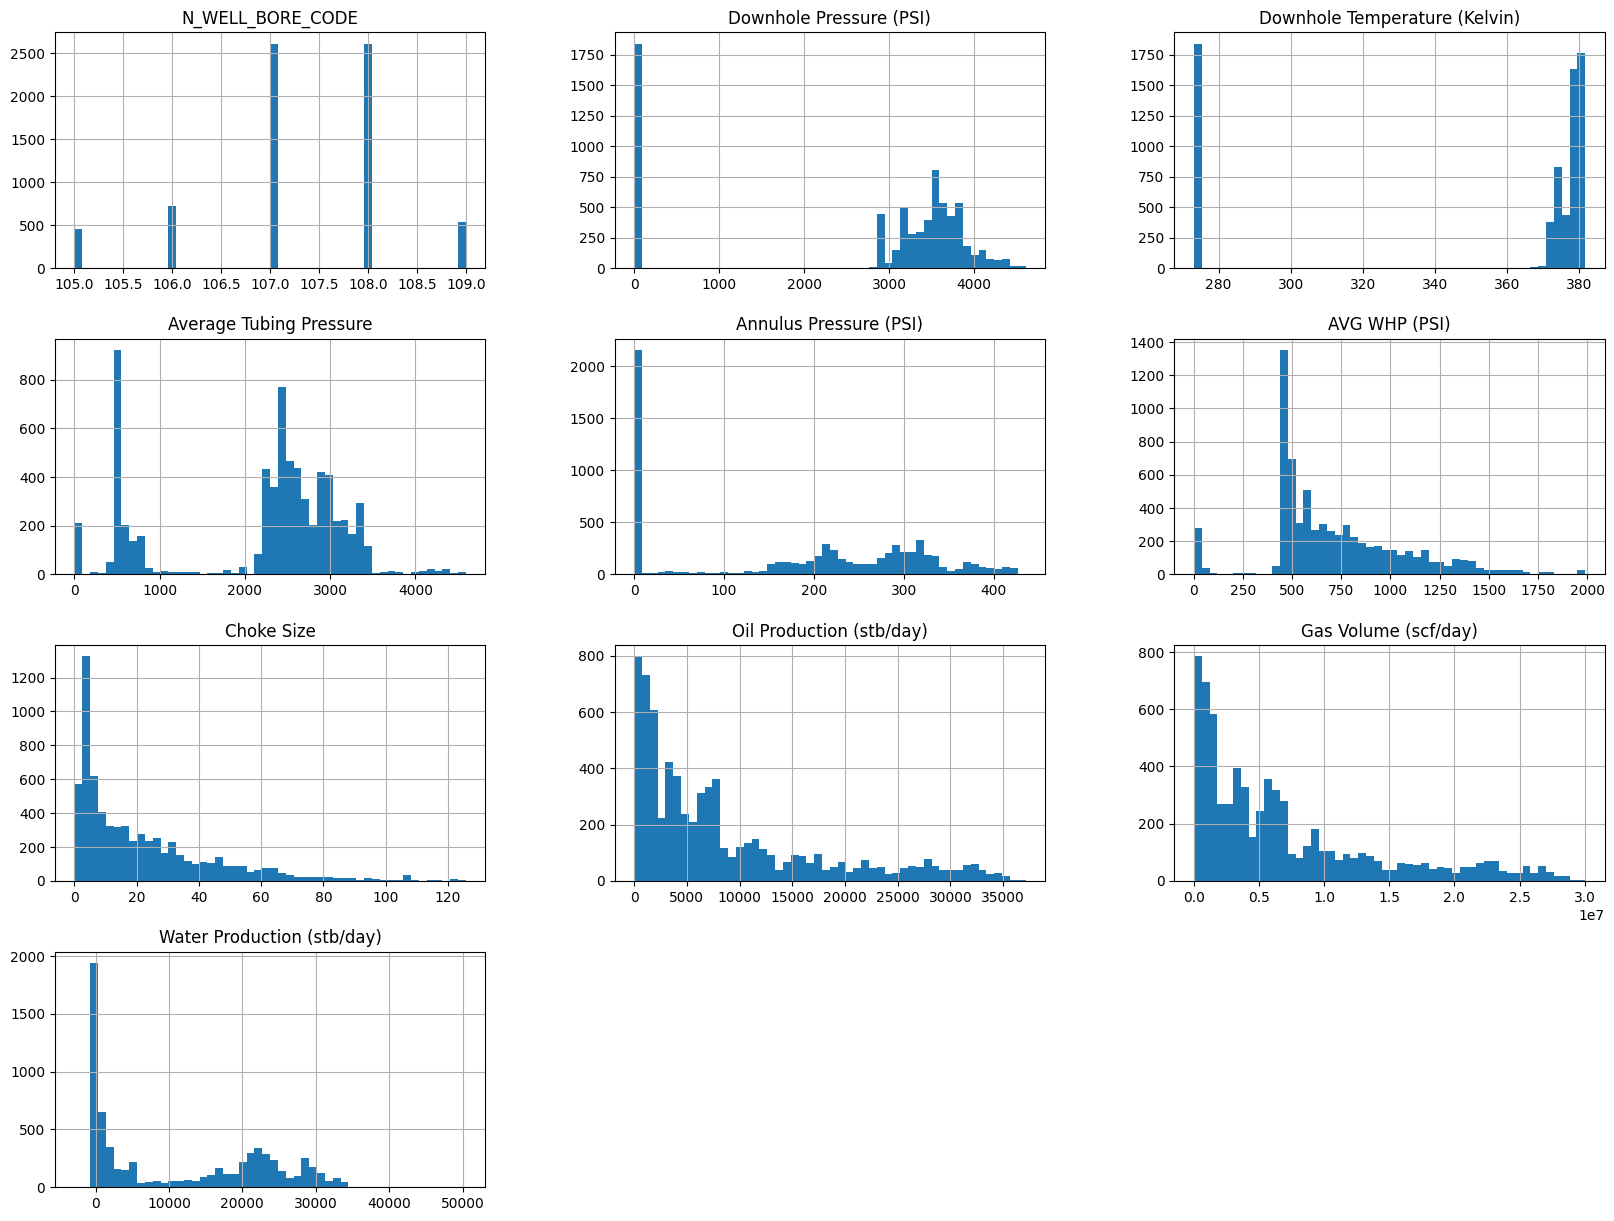

In [ ]:
#Exploratory Data Analysis
#Univariate Analysis
train_data.hist(bins=50, figsize=(20, 15))
plt.show()
# The histogram shows the distribution of each column in the dataset

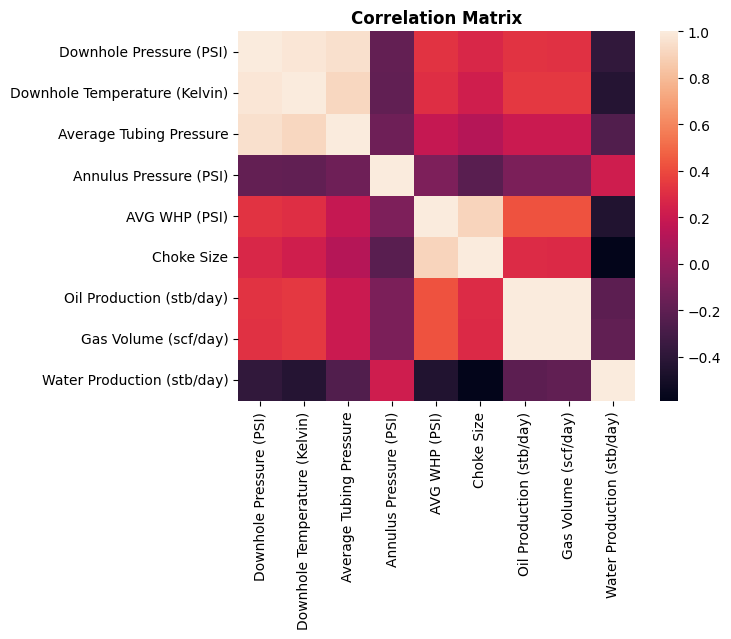

In [ ]:
#Multivariate Analysis
corr_matrix = train_data.iloc[:,7:].corr()
sns.heatmap(corr_matrix, )
plt.title("Correlation Matrix", fontweight = "bold")
plt.show()

In [ ]:
#Scatter matrix showing the pair plots of features
from pandas.plotting import scatter_matrix
scatter_matrix(train_data.iloc[:,7:], figsize=(20, 25))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Partition Data
Trwell = [None] * 5
Tewell = [None] * 5
for k in range(5):
    n = len(Twell[k])
    id_tr = range(int(0.85 * n))
    id_te = range(int(0.85 * n), n)
    Trwell[k] = Twell[k].iloc[id_tr]
    Tewell[k] = Twell[k].iloc[id_te]


In [ ]:
# Extract Predictors
Wellpred = [None] * 5
for k in range(5):
    Wellpred[k] = Trwell[k].iloc[:, 7:16]

In [ ]:
# Clean Data by replacing negative values and NaNs
for k in range(5):
    well_pred = Wellpred[k]
    neg = well_pred.values < 0
    no_negative_data = np.count_nonzero(neg)
    id1 = well_pred.isna()
    no_missing_data = id1.sum().sum()

    if no_negative_data > 0:
        well_pred[neg] = np.nan
        well_pred.fillna(0, inplace=True)
    elif no_missing_data > 0:
        well_pred.interpolate(method='linear', inplace=True)


In [ ]:
# Extract Features and Targets
Wellpredf = [None] * 5
Welltar = [None] * 5
for k in range(5):
    Wellpredf[k] = Wellpred[k].iloc[:-1, :9]
    Welltar[k] = Wellpred[k].iloc[1:, 6:9]


In [ ]:
# Normalize Data
scalers_x = [StandardScaler() for _ in range(5)]
scalers_y = [StandardScaler() for _ in range(5)]
for k in range(5):
    Wellpredf[k] = scalers_x[k].fit_transform(Wellpredf[k])
    Welltar[k] = scalers_y[k].fit_transform(Welltar[k])

    missing = np.isnan(Wellpredf[k]).sum()
    if missing > 0:
        Wellpredf[k] = np.nan_to_num(Wellpredf[k])


In [ ]:
# Prepare Test Data for Recurrent Neural Network
TeWellpred = [None] * 5
TeWelltar = [None] * 5
for k in range(5):
    TeWellpred[k] = Tewell[k].iloc[:-1, 7:16]
    TeWelltar[k] = Tewell[k].iloc[1:, 13:16]

# Normalize Test Data
for k in range(5):
    TeWellpred[k] = scalers_x[k].transform(TeWellpred[k])
    TeWelltar[k] = scalers_y[k].transform(TeWelltar[k])

    missing = np.isnan(TeWellpred[k]).sum()
    if missing > 0:
        TeWellpred[k] = np.nan_to_num(TeWellpred[k])


In [ ]:
# Convert data to numpy arrays
for k in range(5):
    Wellpredf[k] = Wellpredf[k]
    Welltar[k] = Welltar[k]


In [ ]:
# Reshape data for LSTM (add a time step dimension)
for k in range(5):
    Wellpredf[k] = Wellpredf[k].reshape(Wellpredf[k].shape[0], 1,Wellpredf[k].shape[1])
    TeWellpred[k] = TeWellpred[k].reshape(TeWellpred[k].shape[0], 1, TeWellpred[k].shape[1])

In [ ]:

# Define LSTM Neural Network Architecture
model = Sequential()
model.add(InputLayer((1,9)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dense(3))
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               141312    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 8)                 2056      
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 143395 (560.14 KB)
Trainable params: 143395 (560.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
for k in range(5):
  model.fit(Wellpredf[k], Welltar[k], validation_data=(TeWellpred[k], TeWelltar[k]), epochs=150, callbacks=[cp])

Epoch 1/150
12/12 [==============================] - 21s 1s/step - loss: 0.9858 - root_mean_squared_error: 0.9929 - val_loss: 1.7452 - val_root_mean_squared_error: 1.3211
Epoch 2/150
12/12 [==============================] - 12s 1s/step - loss: 0.9461 - root_mean_squared_error: 0.9727 - val_loss: 1.6893 - val_root_mean_squared_error: 1.2997
Epoch 3/150
12/12 [==============================] - 15s 1s/step - loss: 0.9104 - root_mean_squared_error: 0.9542 - val_loss: 1.6377 - val_root_mean_squared_error: 1.2797
Epoch 4/150
12/12 [==============================] - 14s 1s/step - loss: 0.8757 - root_mean_squared_error: 0.9358 - val_loss: 1.5849 - val_root_mean_squared_error: 1.2589
Epoch 5/150
12/12 [==============================] - 13s 1s/step - loss: 0.8439 - root_mean_squared_error: 0.9187 - val_loss: 1.5404 - val_root_mean_squared_error: 1.2411
Epoch 6/150
12/12 [==============================] - 14s 1s/step - loss: 0.8114 - root_mean_squared_error: 0.9008 - val_loss: 1.4945 - val_root_m

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [ ]:
# save model
model.save(Path + '/model4.keras')

In [ ]:
# Load the saved model
#model = tf.keras.models.load_model(Path + '/model4.keras')

In [ ]:
def predictor(model,X,y,start=0, end=100):
  predictions = model.predict(X)
  oil_preds, gas_preds, Water_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2]
  oil_actuals, gas_actuals,Water_actuals = y[:, 0], y[:, 1], y[:, 2]
  train_results = pd.DataFrame(data={'Oil Predictions': oil_preds,
                          'Oil Actuals':oil_actuals,
                          'Gas Predictions': gas_preds,
                          'Gas Actuals': gas_actuals,
                          'Water Predictions': Water_preds,
                          'Water Actuals': Water_actuals
                          })
  fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

  # Oil
  axs[0].plot(train_results['Oil Predictions'][start:end], label='Oil Predictions')
  axs[0].plot(train_results['Oil Actuals'][start:end], label='Oil Actuals')
  axs[0].set_ylabel('Oil Values')
  axs[0].legend()
  axs[0].set_title('Oil Predictions vs Actuals')

  # Gas
  axs[1].plot(train_results['Gas Predictions'][start:end], label='Gas Predictions')
  axs[1].plot(train_results['Gas Actuals'][start:end], label='Gas Actuals')
  axs[1].set_ylabel('Gas Values')
  axs[1].legend()
  axs[1].set_title('Gas Predictions vs Actuals')

  # Water
  axs[2].plot(train_results['Water Predictions'][start:end], label='Water Predictions')
  axs[2].plot(train_results['Water Actuals'][start:end], label='Water Actuals')
  axs[2].set_ylabel('Water Values')
  axs[2].set_xlabel('Time Steps')
  axs[2].legend()
  axs[2].set_title('Water Predictions vs Actuals')

  plt.tight_layout()
  plt.show()
  return train_results[start:end]


Enter the well number (0-4 representing 105 to 109)3
70/70 [==============================] - 1s 3ms/step - loss: 0.1705 - root_mean_squared_error: 0.4129
Training Loss: [0.17052403092384338, 0.4129455089569092]
70/70 [==============================] - 1s 3ms/step


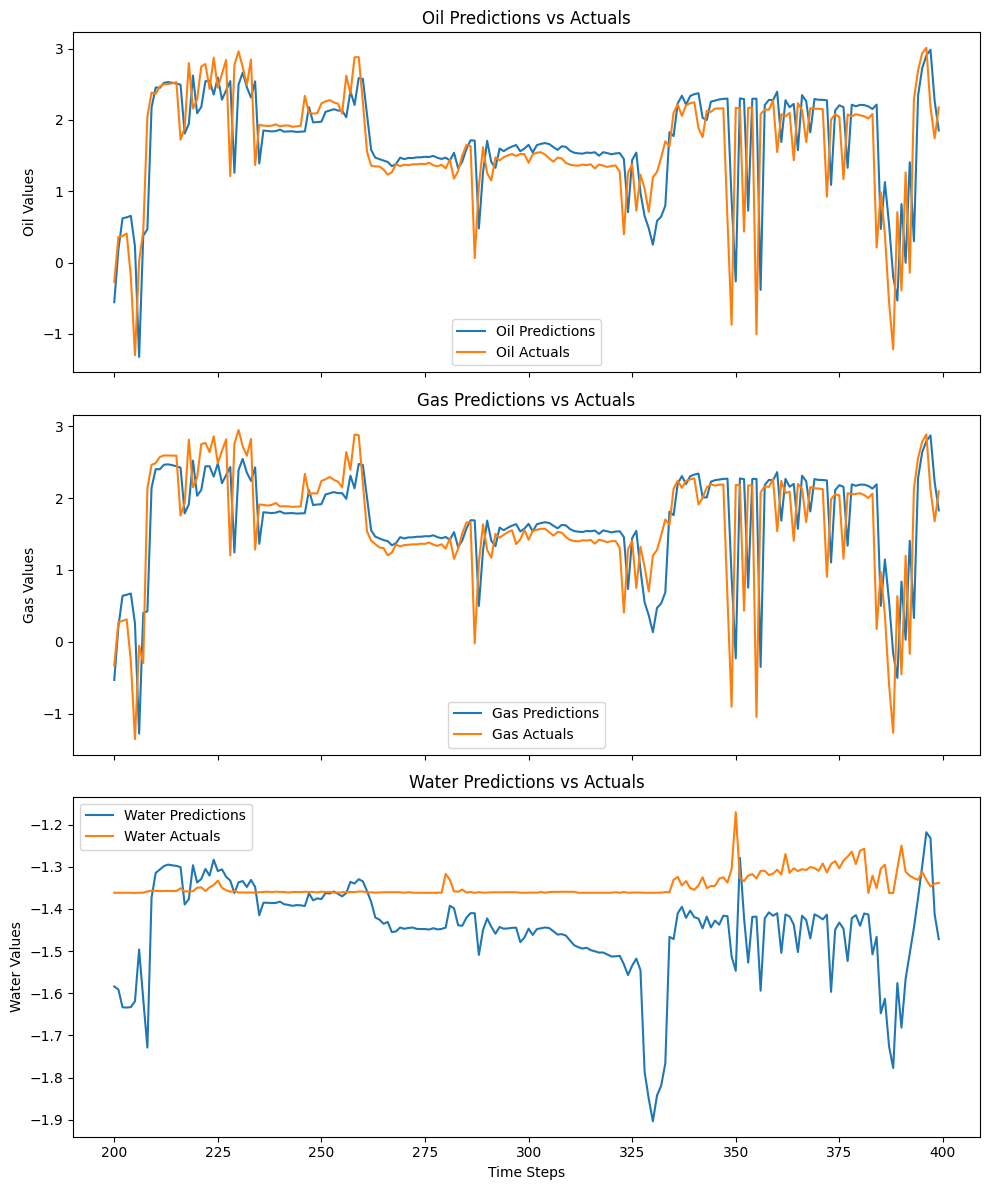

,Oil Predictions,Oil Actuals,Gas Predictions,Gas Actuals,Water Predictions,Water Actuals
200,-0.555705,-0.270031,-0.530446,-0.330986,-1.583793,-1.361510
201,0.182718,0.356820,0.212180,0.273616,-1.590917,-1.361504
202,0.620063,0.373621,0.639808,0.291928,-1.633093,-1.361465
203,0.634586,0.406916,0.654268,0.312107,-1.633695,-1.361498
204,0.654888,-0.196011,0.672605,-0.267790,-1.632766,-1.361536
...,...,...,...,...,...,...
395,2.723401,2.935190,2.637637,2.783895,-1.298683,-1.311907
396,2.903147,3.011253,2.791041,2.884994,-1.218048,-1.330727
397,2.984099,2.179211,2.871204,2.113971,-1.232028,-1.346623
398,2.269095,1.742870,2.225332,1.676885,-1.412310,-1.340031


In [ ]:
# Comparison of prediction on Training Data
k = input("Enter the well number (0-4 representing 105 to 109)")
k = int(k)
trainingloss = model.evaluate(Wellpredf[k], Welltar[k])
print(f'Training Loss: {trainingloss}')
predictor(model,Wellpredf[k],Welltar[k],start=200,end=400)


4/4 [==============================] - 0s 4ms/step - loss: 0.2557 - root_mean_squared_error: 0.5057
Validation Loss: [0.25573572516441345, 0.5057032108306885]
4/4 [==============================] - 0s 3ms/step


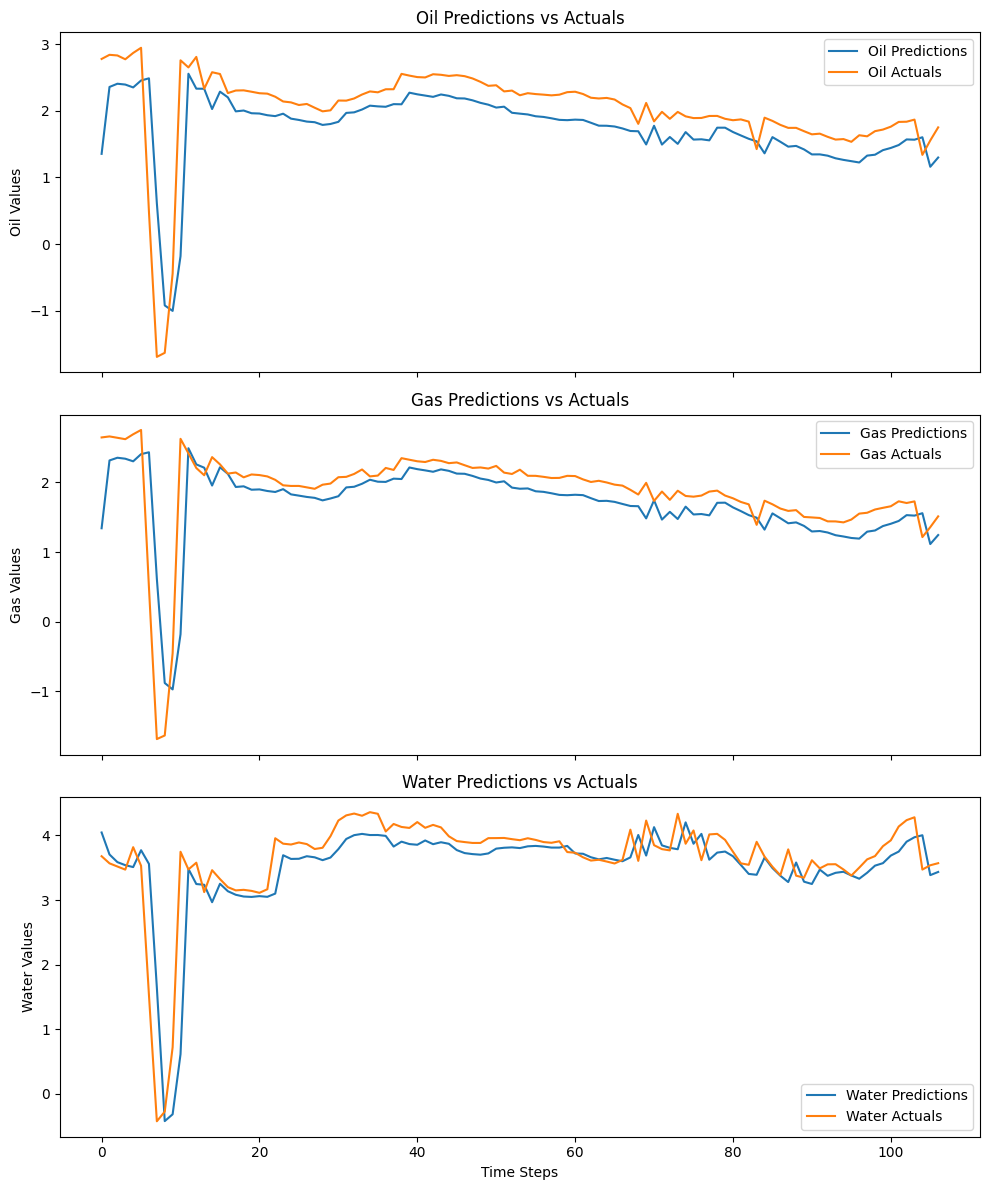

,Oil Predictions,Oil Actuals,Gas Predictions,Gas Actuals,Water Predictions,Water Actuals
0,1.353834,2.775966,1.341549,2.647050,4.046614,3.678410
1,2.356422,2.837946,2.316369,2.661680,3.705583,3.568138
2,2.404620,2.828472,2.355252,2.642176,3.586989,3.519309
3,2.392337,2.771122,2.341328,2.622015,3.539705,3.471065
4,2.349444,2.866260,2.303859,2.692651,3.510276,3.818721
...,...,...,...,...,...,...
102,1.570087,1.835452,1.530246,1.704656,3.903989,4.237768
103,1.566061,1.867058,1.523352,1.727804,3.972918,4.282111
104,1.602556,1.338702,1.558036,1.214939,4.003978,3.471910
105,1.160421,1.554695,1.114545,1.357834,3.385592,3.538424


In [ ]:
# Comparison of prediction on validation Data
k = input("Enter the well number (0-4 representing 105 to 109)")
k = int(k)
valloss = model.evaluate(TeWellpred[k], TeWelltar[k])
print(f'Validation Loss: {valloss}')
predictor(model,TeWellpred[k],TeWelltar[k],start=0,end=200)


In [ ]:
loss = np.zeros((5,2))
val_loss = np.zeros((5,2))
for k in range(5):
  loss[k] = model.evaluate(Wellpredf[k], Welltar[k])
  val_loss[k] = model.evaluate(TeWellpred[k], TeWelltar[k])


3/3 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361


In [ ]:
#Compute the overall training rmse
ov_Tloss = np.mean(loss[1])
print(f'Training Loss: {ov_Tloss}')

Training Loss: 0.45514115691185


In [ ]:
#Compute the overall Validation rmse
ov_valloss = np.mean(val_loss[1])
print(f'Validation Loss: {ov_valloss}')

Validation Loss: 0.38071946799755096


In [ ]:
# Prepare Forecast Data
Vwell = [None] * 5
for k in range(5):
    id_mask = validation_data.iloc[:, 3] == 104 + k + 1
    Vwell[k] = validation_data[id_mask].iloc[:, 7:16]
    Vwell[k] = scalers_x[k].transform(Vwell[k])
    Vwell[k] = pd.DataFrame(Vwell[k]).fillna(0).values


In [ ]:
# Forecast Validation Data
Mc = [None] * 5
Yvc = [None] * 5
Zvc = [None] * 5
for idx in range(5):
    Xv = Vwell[idx]
    Tr = scalers_x[idx].transform(Wellpred[idx])
    TT = scalers_x[idx].transform(Tewell[idx].iloc[:, 7:16].values)
    W = np.vstack((Tr, TT))

    offset = len(W)
    W = W[:offset].reshape(W.shape[0],1,W.shape[1])
    Zv = model.predict(W[:offset])
    Yv = np.zeros((len(Xv), 3))
    Yv[0] = Zv[-1]
    W = W.reshape(W.shape[0]*W.shape[1],W.shape[2])
    M = np.vstack((W, Xv))
    for t in range(1, len(Yv)):
        Xt = np.concatenate((M[offset + t - 1, :6], Yv[t - 1]))
        print("Shape of Xt:", Xt.shape)
        Xt = np.expand_dims(Xt, axis=0)  # Add batch dimension
        Xt = np.expand_dims(Xt, axis=1)  # Add time step dimension
        print("Shape of Xt after expand_dims:", Xt.shape)  # Debugging statement to check the shape after expand_dims

        Yv[t] = model.predict(Xt)

    Yvc[idx] = Yv
    Zvc[idx] = Zv
    Mc[idx] = M

15/15 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 32ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 33ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 34ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 33ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 33ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 35ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 30ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 33ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 45ms/step
S

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


23/23 [==============================] - 0s 6ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 24ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 20ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 27ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 22ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


82/82 [==============================] - 0s 3ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 25ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 22ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 25ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 22ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 25ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 27ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 24ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


82/82 [==============================] - 0s 3ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 31ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 26ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 27ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 23ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 20ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 20ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


17/17 [==============================] - 0s 5ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 34ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 31ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 34ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 24ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 24ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 21ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 28ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)
1/1 [==============================] - 0s 31ms/step
Shape of Xt: (9,)
Shape of Xt after expand_dims: (1, 1, 9)


In [ ]:
# Visualize Forecast

# Define Lab variable for labeling
Lab = ["Oil", "Gas", "Water"]

def visualize_forecast(Mt, Yvt, off, numTimeSteps,id):

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    fig.suptitle(f"Well {id+105} Closed Loop Forecasting")

    for i in range(3):
        axs[i].plot(Mt[:off-1, 6 + i], label="Input")
        axs[i].plot(range(off-1, numTimeSteps), np.concatenate(([Mt[off-1, 6 + i]], Yvt[:, i])), '--', label="Forecasted")
        axs[i].set_ylabel(Lab[i])
        axs[i].legend()

    axs[2].set_xlabel("Time Step")
    plt.show()


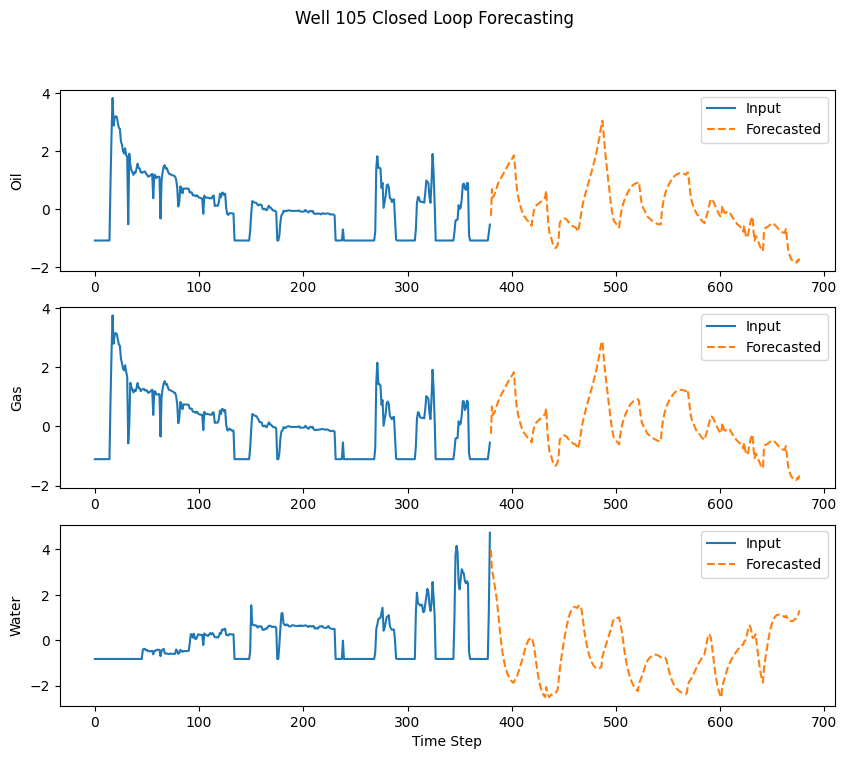

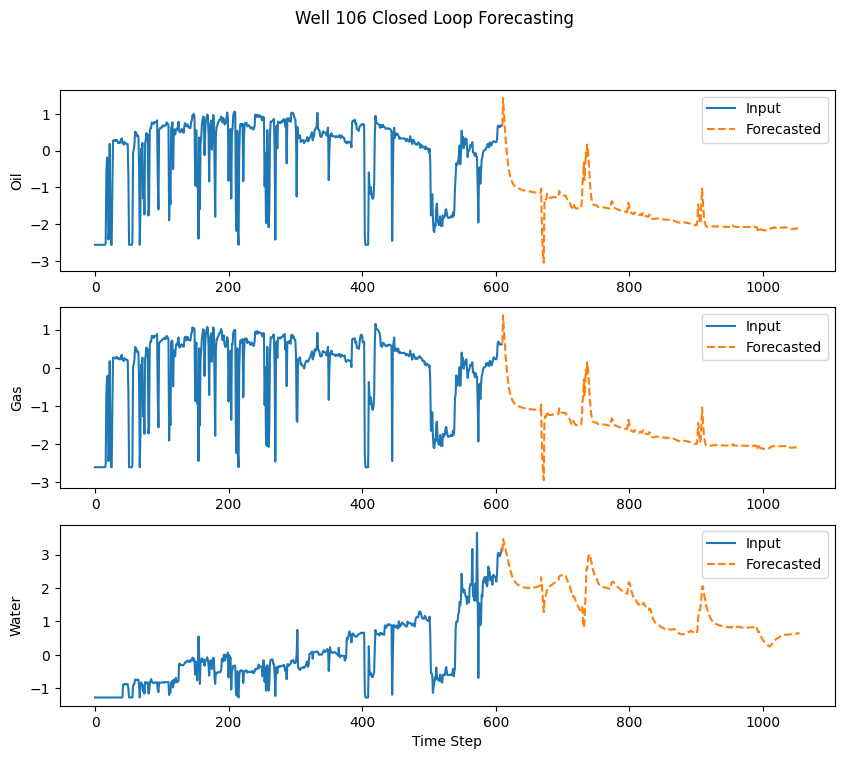

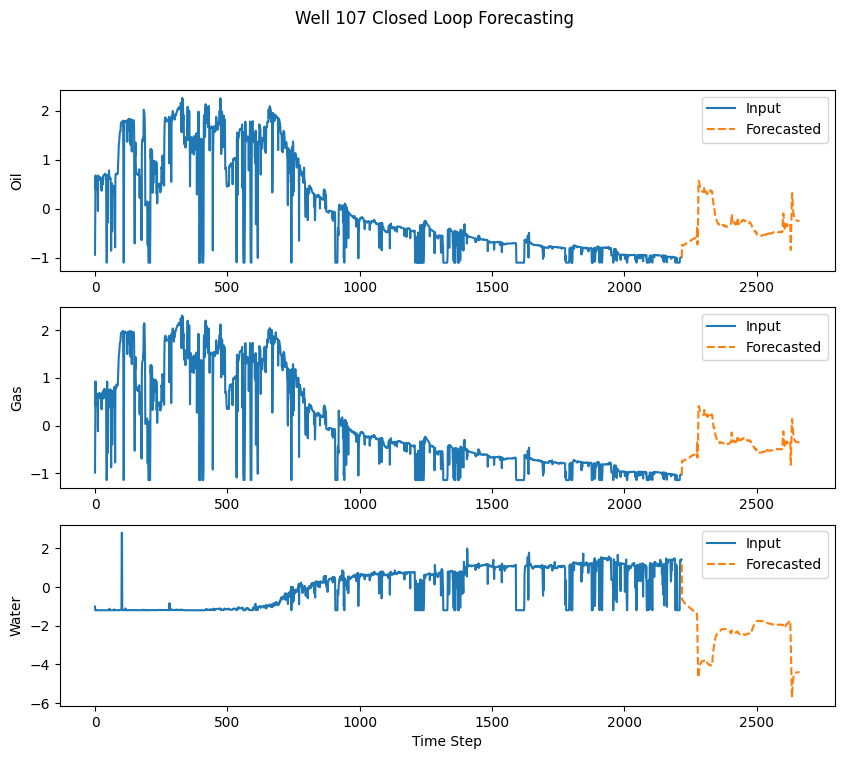

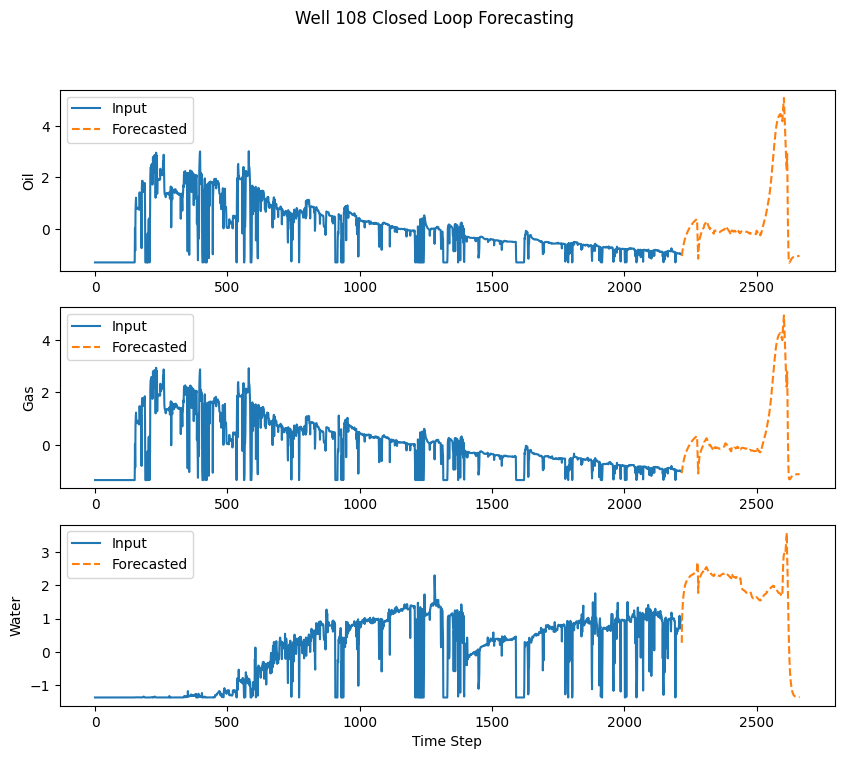

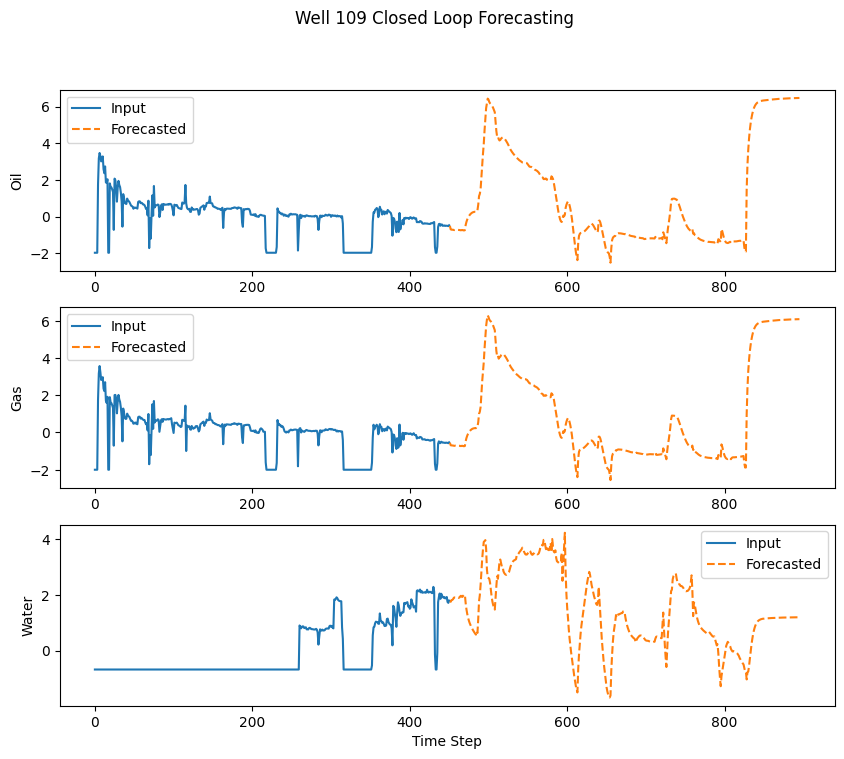

In [ ]:
# Visualization
for idx in range(5):
    Xv = Vwell[idx]
    W = Wellpredf[idx]
    offset1 = len(W)
    numTimeSteps = offset1 + len(Xv)
    visualize_forecast(Mc[idx], Yvc[idx], offset1, numTimeSteps,idx)




In [ ]:
# Convert Forecasted to Original Values
Ypred = [None] * 5
for k in range(5):
    Ypred[k] = scalers_y[k].inverse_transform(Yvc[k])

varnames = validation_data.columns
D = np.concatenate(Ypred)

validation_data.iloc[:, 13:16] = pd.DataFrame(D)
validation_data = validation_data[:len(D)]
print(validation_data)

          PRODUCTION DATE Field Name    WELL_BORE_CODE  N_WELL_BORE_CODE  \
0     2015-07-01 00:00:00      DSEAT   DSEAT-001-F-1 C             105.0   
1     2015-07-02 00:00:00      DSEAT   DSEAT-001-F-1 C             105.0   
2     2015-07-03 00:00:00      DSEAT   DSEAT-001-F-1 C             105.0   
3     2015-07-04 00:00:00      DSEAT   DSEAT-001-F-1 C             105.0   
4     2015-07-05 00:00:00      DSEAT   DSEAT-001-F-1 C             105.0   
...                   ...        ...               ...               ...   
2070  2016-09-12 00:00:00      DSEAT  DSEAT-001-F-15 D             109.0   
2071  2016-09-13 00:00:00      DSEAT  DSEAT-001-F-15 D             109.0   
2072  2016-09-14 00:00:00      DSEAT  DSEAT-001-F-15 D             109.0   
2073  2016-09-15 00:00:00      DSEAT  DSEAT-001-F-15 D             109.0   
2074  2016-09-16 00:00:00      DSEAT  DSEAT-001-F-15 D             109.0   

     WellBore Name   FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
0        001-F-1 C

In [ ]:
validation_data.to_csv("forecast3.csv", index=False)